In [1]:
import numpy as np
import pandas as pd

path = "avg/"
sub_path = "d7/0-dmsp.xlsx"

host_path = "data/algae/" + path + sub_path
bacteria_path = "data/bacteria/" + path + sub_path

df_host = pd.read_excel(host_path, header=None)
df_bacteria = pd.read_excel(bacteria_path, header=None)
df_bacteria = df_bacteria.replace(0, np.nan)

df_host_time = df_host.iloc[:, 0]
host = df_host.iloc[:, 1].tolist()

df_bacteria_time = df_bacteria.iloc[:, 0]
bacteria = df_bacteria.iloc[:, 1].tolist()

time = df_host_time.tolist()
#time = time[1:]

log_host = np.log(np.array(host) + 1e-9)
log_bacteria = np.log(np.array(bacteria) + 1e-9)

save_path = "figures/0-path/" + host_path.replace("/", "_")
save_path = save_path[:-5].replace("data_algae_", "").strip()


In [2]:
def ode_system(t, y, params):
    H = y[0]
    P = y[1]
    B = y[2]

    muH = params[0]
    muB = params[1]
    k = params[2]
    phi = params[3]
    beta = params[4]
    kB = params[5]

    dHdt = (muH * H * (1 - (H / k) )) - phi * H * P
    dPdt = beta * phi * H * P
    dBdt = (muB * B * (1 - (B / kB) ))
    return [dHdt, dPdt, dBdt]

In [3]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:6] # first 6
        y0 = theta_y0[6:] # last 3

        sol = solve_ivp(
            fun=lambda t, y: ode_system(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [6]:
import pymc as pm

ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    
    #muH = pm.Uniform("muH", lower=.5, upper=1)
    muH = pm.Lognormal("muH", mu=np.log(0.87), sigma=.1)
    
    muB = pm.Uniform("muB", lower=0, upper=1)
    #muB = pm.Lognormal("muB", mu=np.log(0.5), sigma=.1) 
    
    #k = pm.Uniform("k", lower=1e6, upper=2e7)
    k = pm.Lognormal("k", mu=np.log(5.4e6), sigma=.1)

    #phi = pm.Uniform("phi", lower=0, upper=2.5e-7)
    phi = pm.Lognormal("phi", mu=np.log(7.1e-9), sigma=0.1)

    beta = pm.Uniform("beta", lower=0, upper=100)
    #beta = pm.Lognormal("beta", mu=np.log(.2), sigma=0.1)

    kB = pm.Uniform("kB", lower=1e6, upper=2e7)

    #gamma = pm.Deterministic("gamma", phi * beta)

    H0 = pm.Uniform("H0", lower=2e5, upper=1e7)
    #H0 = pm.Lognormal("H0", mu=np.log(.4e6), sigma=0.1)

    P0 = pm.Uniform("P0", lower=2e5, upper=6e7)

    B0 = pm.Uniform("B0", lower=2e4, upper=1e7)
    #B0 = pm.Lognormal("B0", mu=np.log(21), sigma=0.1)

    
    sigma_host = pm.HalfNormal("sigma_host", sigma=1)
    #sigma_pathogen = pm.HalfNormal("sigma_pathogen", sigma=1)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", sigma=1)

    ode_solution = ode_op(pt.stack([muH, muB, k, phi, beta, kB, H0, P0, B0]))

    pm.Normal(
        "host_obs",
        mu=pm.math.log(ode_solution[:, 0] + 1e-9),
        sigma=sigma_host,
        observed=log_host
    )

    #pm.Normal(
    #    "pathogen_obs",
    #    mu=pm.math.log(ode_solution[:, 1] + 1e-9),
    #    sigma=sigma_pathogen,
    #    observed=log_d7
    #)

    pm.Normal(
        "bacteria_obs",
        mu=pm.math.log(ode_solution[:, 2] + 1e-9),
        sigma=sigma_bacteria,
        observed=log_bacteria
    )

In [7]:
with model:
    trace = pm.sample(draws=10000, 
                      tune=10000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                     ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muH]
>Metropolis: [muB]
>Metropolis: [k]
>Metropolis: [phi]
>Metropolis: [beta]
>Metropolis: [kB]
>Metropolis: [H0]
>Metropolis: [P0]
>Metropolis: [B0]
>Metropolis: [sigma_host]
>Metropolis: [sigma_bacteria]


Output()

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 246 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [8]:
import arviz as az
import matplotlib.pyplot as plt
az.summary(
    trace,
    #var_names=["muH", "muB", "k", "phi", "beta", "gamma", "H0", "P0", "B0",
               #"sigma_host", "sigma_pathogen", "sigma_bacteria"],
    round_to=10
)

# Take note of ess_bulk and r_hat values

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
muH,8.631314e-01,8.400000e-02,7.120792e-01,1.028023e+00,0.001268,0.000790,4333.124940,5231.528549,1.001679
muB,7.703038e-01,1.928914e-01,4.096787e-01,9.999899e-01,0.003462,0.002539,3228.727789,4710.583372,1.000410
k,5.532025e+06,5.402922e+05,4.558977e+06,6.556419e+06,8619.246756,4968.038993,3921.807256,6325.046610,1.002554
phi,7.000000e-09,7.000000e-10,5.800000e-09,8.300000e-09,0.000000,0.000000,1899.930890,3967.353574,1.003023
beta,2.388608e+01,8.285311e+00,7.384366e+00,3.891312e+01,0.392556,0.209469,445.192796,663.372354,1.011091
kB,1.549311e+07,3.519616e+06,8.978389e+06,1.999746e+07,41423.726317,31424.208033,7098.845026,8518.232890,1.000783
H0,6.518081e+05,7.818549e+05,2.001974e+05,1.508730e+06,19875.296718,46926.339989,1329.569085,2244.493822,1.001244
P0,9.315582e+06,1.200418e+07,2.000485e+05,3.481729e+07,445274.042354,358910.828856,533.452024,1409.952933,1.009849
B0,8.685874e+05,1.440872e+06,2.027303e+04,3.363710e+06,25058.453873,39777.719361,3041.538856,5094.600179,1.001195
sigma_host,8.982267e-01,2.636726e-01,4.649778e-01,1.379062e+00,0.008079,0.004418,1032.125234,3035.288219,1.003760


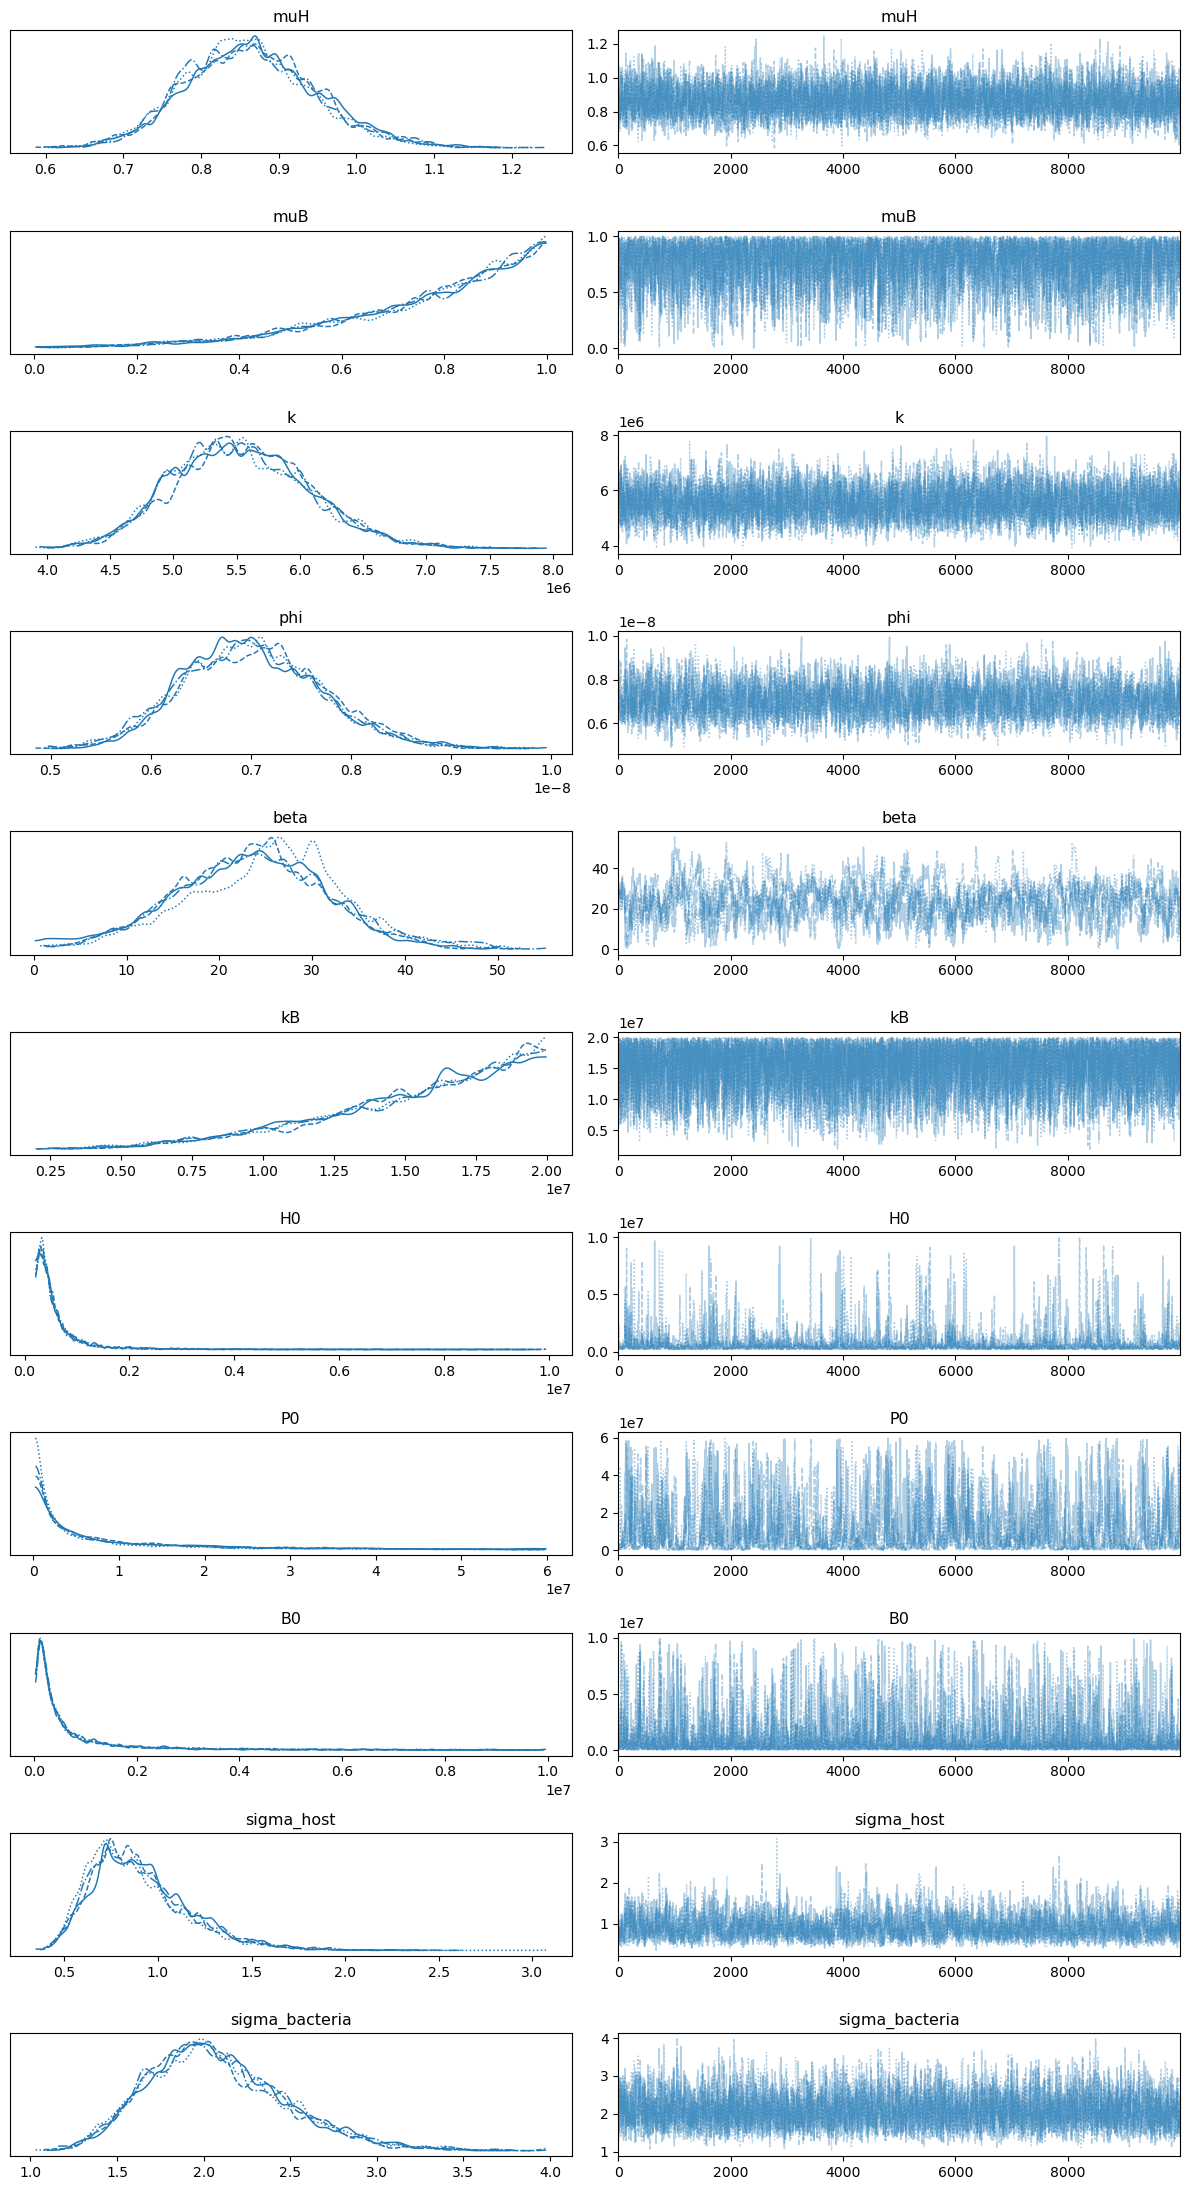

In [9]:
az.plot_trace(trace, 
              #var_names=["muH", "muB", "k", "phi", "beta", "gamma", "H0", "P0", "B0", "sigma_host", "sigma_pathogen", "sigma_bacteria"],
              backend_kwargs={"tight_layout": True})
plt.savefig(save_path + "-trace-remodel.png")
plt.show()

## SOME GPT5 Post Processing

In [13]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        k0      = float(posterior["k"].values[c, d])
        phi0    = float(posterior["phi"].values[c, d])
        beta0  = float(posterior["beta"].values[c, d])
        kB0    = float(posterior["kB"].values[c, d])

        H00 = float(posterior["H0"].values[c, d])
        P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muH0, muB0, k0, phi0, beta0, kB0], dtype=float)
        y0 = [H00, P00, B00]

        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims


In [14]:
import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    host,
    #d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    host = np.asarray(host, dtype=float)
    #d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    series = [host, bacteria]
    labels = ["Host", "Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


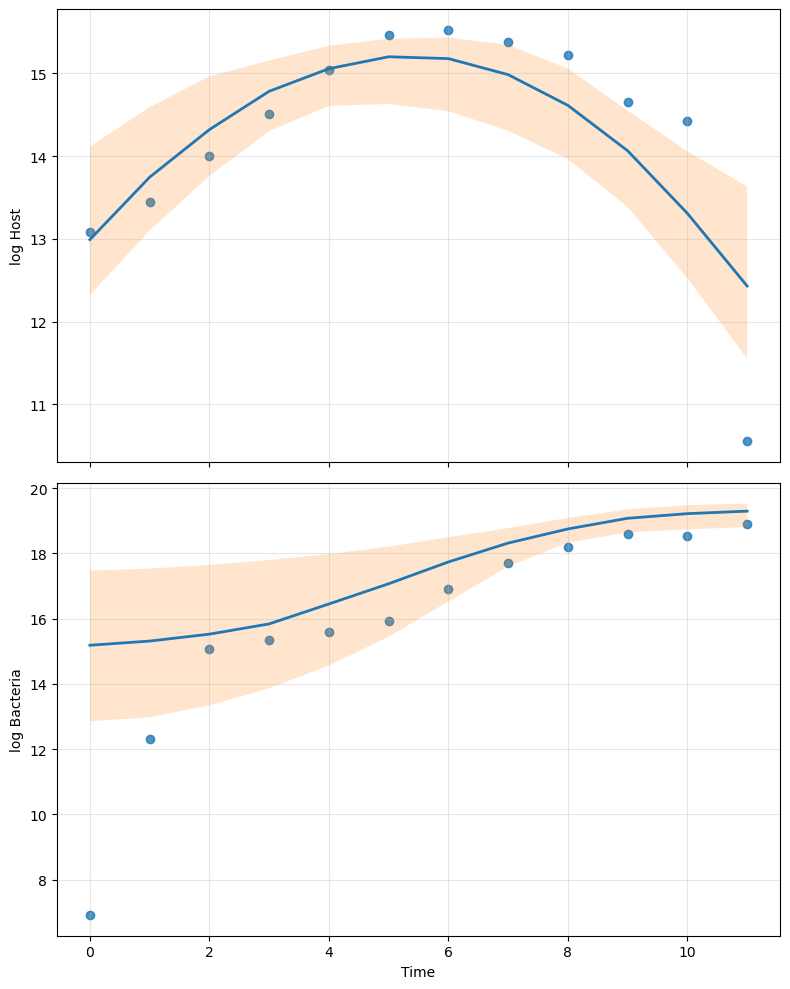

In [15]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    host=host,
    #d7=None,
    bacteria=bacteria,
    ode_rhs=ode_system,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
plt.savefig(save_path + "-posterior-fit-remodel.png")
plt.show()